In [1]:
conda env list

# conda environments:
#
NewEnv                   /home/achartra/.conda/envs/NewEnv
PINNICLEenv           *  /home/achartra/.conda/envs/PINNICLEenv
allison                  /home/achartra/.conda/envs/allison
baseclone                /home/achartra/.conda/envs/baseclone
base                     /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05
earthml                  /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05/envs/earthml
esmvaltool               /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05/envs/esmvaltool
gdalNgmt                 /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05/envs/gdalNgmt
ilab-pytorch             /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05/envs/ilab-pytorch
ilab-tensorflow          /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhel/8.6/3-2022.05/envs/ilab-tensorflow
ml                       /panfs/ccds02/app/modules/anaconda/platform/x86_64/rhe

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-12-20 09:32:44.084065: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-20 09:32:45.516221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734705165.771418  993479 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734705165.846337  993479 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-20 09:32:46.826234: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Num GPUs Available:  1


**1. Set up the modules**<br />

In [1]:
# Testing PINNICLE
# Infer basal friction coefficients using SSA

import pinnicle as pinn
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from datetime import datetime

# Set up some configurations
dde.config.set_default_float('float64')
dde.config.disable_xla_jit()
dde.config.set_random_seed(1234)


2025-01-16 14:18:42.608429: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 14:18:42.631741: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737055122.648894 2814969 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737055122.654096 2814969 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-16 14:18:42.672724: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Set the default float type to float64


**2. Set up the experiment for either SSA or MOLHO**

In [2]:
# Load the correct data

issm_filename = "Ryder_issm2024-Dec-19_3"
datestr = datetime.now().strftime("%y-%b-%d")

issm_pinn_path = issm_filename + "_pinn" + datestr + "_1G"
# General parameters for training
# Setting up dictionaries: order doesn't matter, but keys DO matter
hp = {}
# Define domain of computation
hp["shapefile"] = "./Ryder_32_09.exp"

# Define hyperparameters
hp["epochs"] = int(1e4)
hp["learning_rate"] = 0.001
hp["loss_function"] = "MSE"

yts = pinn.physics.Constants().yts
data_size = 800
data_size_ft = 1000
wt_uv = (1.0e-2*yts)**2.0
wt_uvb = (1.0e-1*yts)**2.0
wt_s = 5.0e-6
wt_H = 1.0e-5
wt_C = 1.0e-8

# Load data
flightTrack = {}
flightTrack["data_path"] = "./Ryder_xyz_ds.mat"
flightTrack["data_size"] = {"H": data_size_ft}
flightTrack["name_map"] = {"H": "thickness"}
flightTrack["X_map"] = {"x": "x", "y":"y"}
flightTrack["source"] = "mat"
hp["data"] = {"ft": flightTrack}

velbase = {}
velbase["data_path"] = "./Ryder_vel_base_ms.mat"
velbase["data_size"] = {"u_base":data_size, "v_base":data_size}
velbase["name_map"] = {"u_base":"md_u_base", "v_base":"md_v_base"}
velbase["X_map"] = {"x":"x", "y":"y"}
velbase["source"] = "mat"

issm = {}
issm["data_path"] = "./Models/" + issm_filename + ".mat"
issm["data_size"] = {"u":data_size, "v":data_size, "s":data_size, "H":None, "C":None} #, "B":10000}
hp["data"] = {"ISSM":issm, "ft":flightTrack, "velbase":velbase} # hp = 'hyperparameters'

# Define number of collocation points used to evaluate PDE residual
hp["num_collocation_points"] = data_size*2


# Add physics
yts = pinn.physics.Constants().yts
# SSA = {}
# SSA["scalar_variables"] = {"B":2e+08, "n":3} # -20 deg C
#                     # u                     v                 s        H      C        B
# SSA["data_weights"] = [(1.0e-2*yts)**2.0, (1.0e-2*yts)**2.0, 5.0e-6, 5.0e-6, 5.0e-8, 1e-16]
# # hp["equations"] = {"SSA":{"input":["x1", "x2"]}}
# hp["equations"] = {"SSA_VB":SSA}

MOLHO = {}
MOLHO["scalar_variables"] = {"B":2e+08}
hp["equations"] = {"MOLHO":MOLHO}
#                       # u     v       u_base  v_base  s     H      C
MOLHO["data_weights"] = [wt_uv, wt_uv, wt_uvb, wt_uvb, wt_s, wt_H, wt_C]

MOLHO["output_lb"] =    [-1.0e4/yts,         -1.0e4/yts,         -1.0e2/yts,         -1.0e2/yts,     -1.0e3,  10.0, 0.01]
MOLHO["output_ub"] =    [1.0e4/yts,           1.0e4/yts,          1.0e2/yts,          1.0e2/yts,      4.0e3,  4.0e3, 1.0e4]
MOLHO["variable_lb"] =  [-1.0e4/yts,         -1.0e4/yts,         -1.0e2/yts,         -1.0e2/yts,     -1.0e3,  10.0, 0.01]
MOLHO["variable_ub"] =  [1.0e4/yts,           1.0e4/yts,          1.0e2/yts,          1.0e2/yts,      4.0e3,  4.0e3, 1.0e4]

hp['fft'] = True
hp['sigma'] = 5
hp['num_fourier_feature'] = 30

# Set NN architecture
hp["activation"] = "tanh"
hp["initializer"] = "Glorot uniform"
hp["num_neurons"] = 20
hp["num_layers"] = 6
hp["input"] = ['y', 'x']

hp['fft'] = True
hp['sigma'] = 5
hp['num_fourier_feature'] = 30

hp["save_path"] = "./PINNs/" + issm_pinn_path
hp["is_save"] = True
hp["is_plot"] = True

experiment = pinn.PINN(hp) # set up class PINN (in pinn.py in pinnicle package)

# experiment.update_parameters(hp)
print(experiment.params) # make sure that settings are in correct spot (keys must be correct)

ERROR:root:ERROR: MATLAB type not supported: qmustatistics, (uint32)
ERROR:root:ERROR: MATLAB type not supported: lovenumbers, (uint32)
ERROR:root:ERROR: MATLAB type not supported: rotational, (uint32)
ERROR:root:ERROR: MATLAB type not supported: solidearthsettings, (uint32)


add Fourier feature transform to input transform
add output transform with [-3.1709792e-04 -3.1709792e-04 -3.1709792e-06 -3.1709792e-06
 -1.0000000e+03  1.0000000e+01  1.0000000e-02] and [3.1709792e-04 3.1709792e-04 3.1709792e-06 3.1709792e-06 4.0000000e+03
 4.0000000e+03 1.0000000e+04]
Parameters: 
	TrainingParameter: 
		epochs:	10000
		optimizer:	adam
		loss_functions:	['MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE', 'MSE']
		additional_loss:	{}
		learning_rate:	0.001
		loss_weights:	[1e-10, 1e-10, 1e-10, 1e-10, 99451929600.0, 99451929600.0, 9945192960000.0, 9945192960000.0, 5e-06, 1e-05, 1e-08]
		has_callbacks:	False
		min_delta:	None
		patience:	None
		period:	None
		checkpoint:	False
		save_path:	./PINNs/Ryder_issm2024-Dec-19_3_pinn25-Jan-16_1G
		is_save:	True
		is_plot:	True
	DomainParameter: 
		shapefile:	./Ryder_32_09.exp
		num_collocation_points:	1600
		time_dependent:	False
		start_time:	0
		end_time:	0
	DataParameter: 
		ISSM:
			data_path:	./Models/Ryd

2025-01-16 14:18:53.619612: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1737055133.619847 2814969 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30826 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


**3. Now run the PINN model**<br />
**4. Save results in a .mat file**

Compiling model...
'compile' took 0.007546 s

Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
0         [5.22e+02, 4.57e+02, 3.76e+02, 3.65e+02, 8.56e+02, 1.52e+03, 1.82e+01, 5.02e+01, 1.24e+01, 1.28e+01, 5.82e-02]    [5.22e+02, 4.57e+02, 3.76e+02, 3.65e+02, 8.56e+02, 1.52e+03, 1.82e+01, 5.02e+01, 1.24e+01, 1.28e+01, 5.82e-02]    []  
10000     [4.31e-03, 1.02e-02, 7.26e-03, 3.93e-02, 3.98e-02, 3.18e-02, 8.82e-03, 8.57e-02, 8.24e-02, 5.54e-02, 9.27e-04]    [4.31e-03, 1.02e-02, 7.26e-03, 3.93e-02, 3.98e-02, 3.18e-02, 8.82e-03, 8.57e-02, 8.24e-02, 5.54e-02, 9.27e-04]    []  

Best model at step 10000:
  train loss: 3.66e-01
  test loss: 3.66e-01
  test metric: []

'train' took 688.074923 s



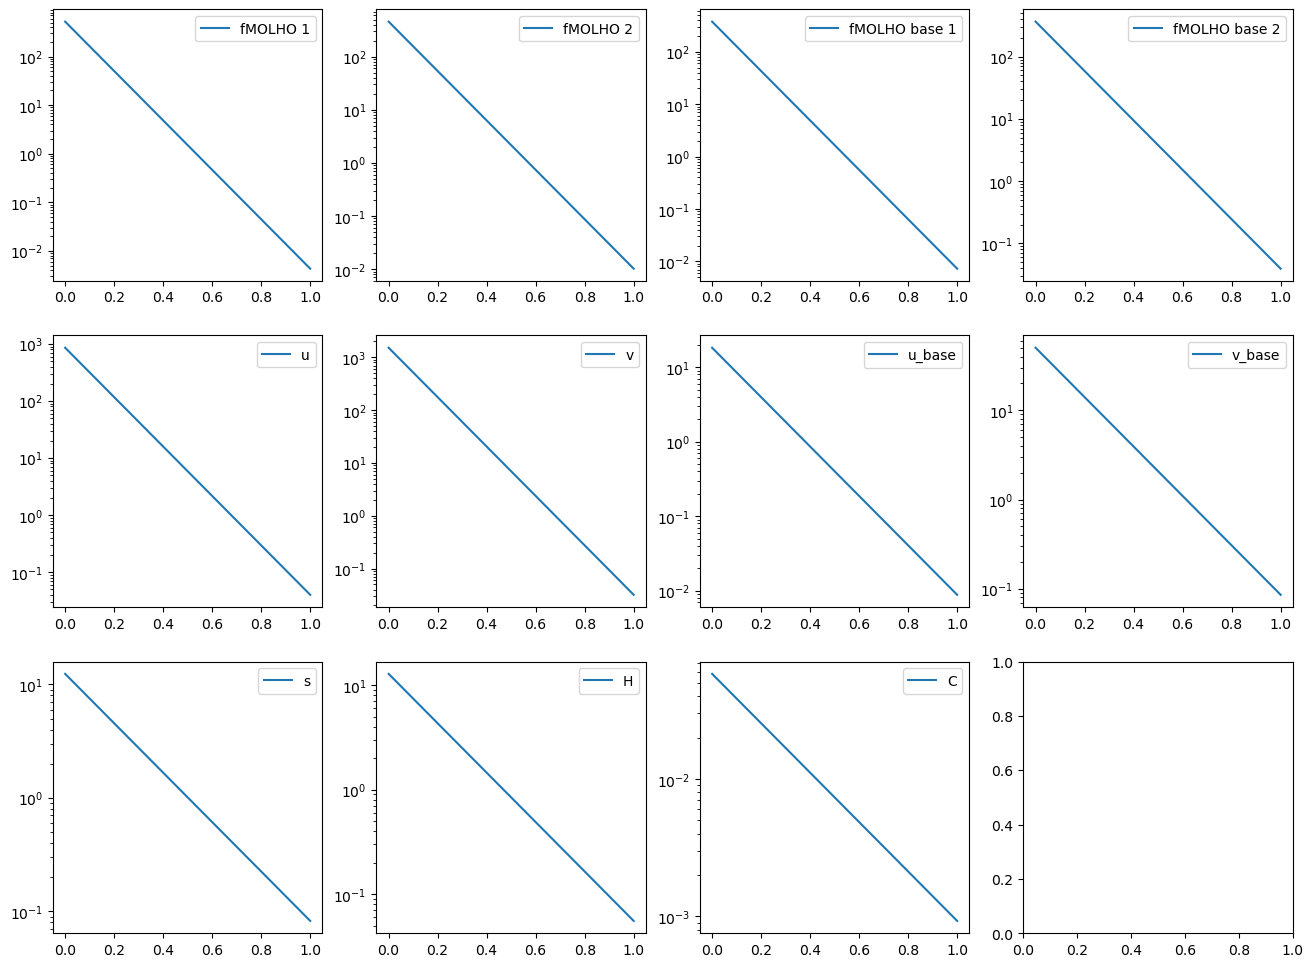

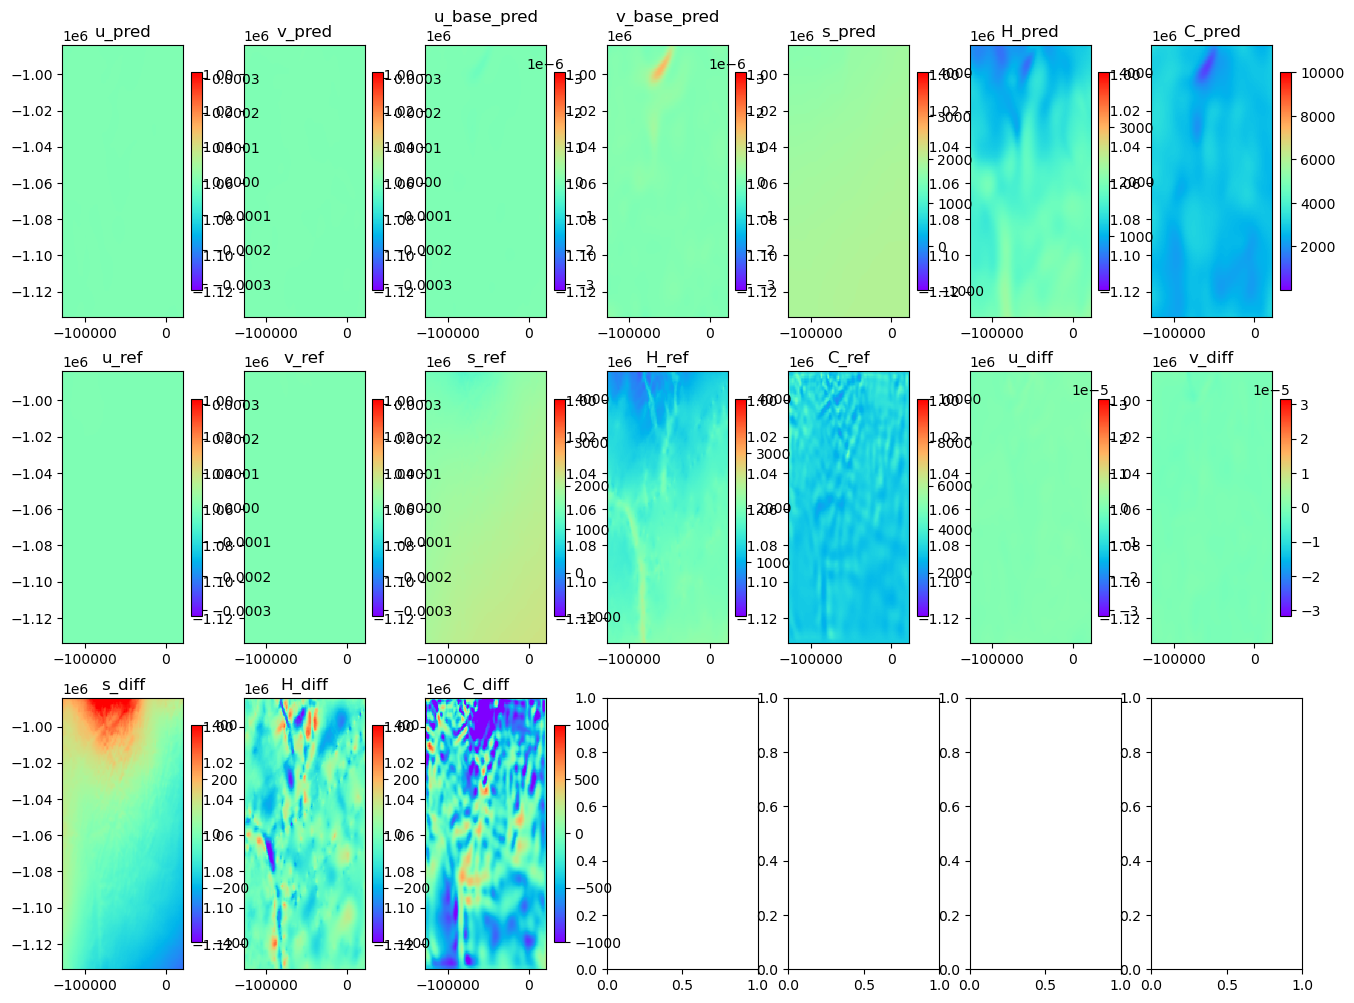

In [3]:
# Now run the PINN model
experiment.compile()

# Train
experiment.train()
# Show results
experiment.plot_predictions(X_ref=experiment.model_data.data["ISSM"].X_dict, 
                            sol_ref=experiment.model_data.data["ISSM"].data_dict)



**4. Save results in a .mat file**

In [4]:
# Save results
import hdf5storage
import scipy

grid_size = 501

    # generate 200x200 mesh on the domain
X, Y = np.meshgrid(np.linspace(experiment.params.nn.input_lb[0], experiment.params.nn.input_ub[0], grid_size),
                   np.linspace(experiment.params.nn.input_lb[1], experiment.params.nn.input_ub[1], grid_size))
X_nn = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

# predicted solutions
sol_pred = experiment.model.predict(X_nn)

mat_data = {} # make a dictionary to store the MAT data in
vars2save = ['sol_pred','X_nn']
for i, var_curr in enumerate(vars2save):
    exec(f'mat_data[u"{var_curr}"] = {var_curr}')
 
hdf5storage.savemat(hp["save_path"] + '/' + issm_pinn_path + '_predictions.mat', mat_data, format='7.3', 
                    oned_as='row', store_python_metadata=True)

**Instead of running a new model, simply load a saved model**<br />
Note: Installed on ADAPT/Prism is an older version of PINNICLE as of 10 Jan 2025, which successfully opens models saved with the older version of PINNICLE but not models saved with the newest version currently installed on my local system.

In [6]:
# Import from previous experiment

import pinnicle as pinn
import numpy as np
import deepxde as dde

# Set up some configurations
dde.config.set_default_float('float64')
dde.config.disable_xla_jit()
dde.config.set_random_seed(1234)

## Load settings from previous experiment
model_path = "./PINNs/Ryder_issm2024-Dec-19_3_pinn25-Jan-28_1G"
experiment = pinn.PINN(loadFrom=model_path)

# If you're going to save this in a new place:
# new_folder = './PINNs/Ryder_issm2024-Dec-19_3_pinn25-Jan-09-1La'
# experiment.update_parameters({"save_path": new_folder})

## Load weights from previously trained NN
experiment.load_model(path=model_path)

2025-01-28 12:52:35.670617: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-28 12:52:36.550129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738086756.756151 3289037 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738086756.838433 3289037 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-28 12:52:37.454874: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Set the default float type to float64


ERROR:root:ERROR: MATLAB type not supported: qmustatistics, (uint32)
ERROR:root:ERROR: MATLAB type not supported: lovenumbers, (uint32)
ERROR:root:ERROR: MATLAB type not supported: rotational, (uint32)
ERROR:root:ERROR: MATLAB type not supported: solidearthsettings, (uint32)


add Fourier feature transform to input transform
add output transform with [-3.1709792e-04 -3.1709792e-04 -3.1709792e-06 -3.1709792e-06
 -1.0000000e+03  1.0000000e+01  1.0000000e-02] and [3.1709792e-04 3.1709792e-04 3.1709792e-06 3.1709792e-06 4.0000000e+03
 4.0000000e+03 1.0000000e+04]
Compiling model...
'compile' took 0.005808 s



2025-01-28 12:52:59.895302: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1738086779.895552 3289037 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:61:00.0, compute capability: 7.0


Compiling model...
'compile' took 0.002586 s



**5. Make my own figures**

In [7]:
# Prepare plotting data - load modules and define functions

import math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from scipy.interpolate import griddata
from scipy.spatial import cKDTree as KDTree
import scipy.io as sio
import pandas as pd
from scipy.stats import iqr

def shadecalc_pre(s, u, v, resolution):
    # CALCULATE SURFACE SLOPE AND ALONG-FLOW SURFACE SLOPE AND MAKE FLOW-AWARE HILLSHADE
    print('Use filtered surface speed with elevation azimuth and calculate along-flow surface slope...')

    speed_filt = np.sqrt(np.square(u) + np.square(v))
    
    # surface-velocity and elevation-gradient flow azimuths
    az_speed = np.arctan2(v, u) # rad
    [elev_grad_y, elev_grad_x] = np.gradient(s, resolution)
    az_elev = np.arctan2(-elev_grad_y, -elev_grad_x) # rad
    
    [num_y, num_x]		= s.shape
    
    # extract trigonometric elements
    az_sin_cat, az_cos_cat = np.full((num_y, num_x, 2), np.nan), np.full((num_y, num_x, 2), np.nan)
    az_sin_cat[:, :, 0] = np.sin(az_speed)
    az_cos_cat[:, :, 0] = np.cos(az_speed)
    az_sin_cat[:, :, 1] = np.sin(az_elev)
    az_cos_cat[:, :, 1] = np.cos(az_elev)
    
    # weight filter exponentially using reference speed
    speed_az_decay = 100 # speed above which weight is unity for InSAR surface speeds, m/s (100 in GBTSv1)
    # speed_uncert_rel_decay = 0.25 # (0.1 in GBTSv1, 0.25 here), also fractional cutoff for speeds
    wt_az_elev = np.exp(-speed_filt / speed_az_decay) # + np.exp(-speed_uncert_rel_decay ./ (speed_uncert_filt ./ speed_filt)) % characteristic length of surface speed to unity ratio
    wt_az_elev[wt_az_elev > 1] = 1
    wt_az_speed = 1 - wt_az_elev
    wt_az_elev[np.isnan(az_speed)] = 1 # maximum weight (1) if the other is NaN
    wt_az_speed[np.isnan(az_elev)] = 1
    az_mean = np.arctan2((az_sin_cat[:, :, 0] * wt_az_speed) + (az_sin_cat[:, :, 1] * wt_az_elev), (az_cos_cat[:, :, 0] * wt_az_speed) + (az_cos_cat[:, :, 1] * wt_az_elev)) # mean azimuth, radians
    az_mean_cos = np.cos(az_mean) # rad
    az_mean_sin = np.sin(az_mean) # rad
    
    # Prepare to fix hillshade wrap issue
    az_wrap_cutoff = 150 # cutoff near 0/360 to address wrapping
    tmp1 = np.mod(np.degrees(az_mean), 360) # current projected Cartesian flow direction
    tmp1[(tmp1 >= az_wrap_cutoff) & (tmp1 <= 360 - az_wrap_cutoff)] = np.nan # add 360 deg to azimuths to get them well away from 0 (the wrapping problem)
    tmp2 = np.copy(tmp1) # interpolate cutoff azimuths onto full DEM grid (100 m)
    tmp3 = np.mod(np.degrees(az_mean), 360) # interpolate original azimuths onto full DEM grid
    tmp3[~np.isnan(tmp2)] = np.mod(tmp2[~np.isnan(tmp2)] - 360, 360) # take interpolated cutoff azimuths, remove the 360 deg, then wrap them, and put them where original azimuths were
    
    # use raw speed azimuth along margin where gridding breaks down
    az_speed = np.mod(np.degrees(np.arctan2(v, u)), 360)
    tmp3[np.isnan(tmp3) * ~np.isnan(az_speed)] = az_speed[np.isnan(tmp3) & ~np.isnan(az_speed)]
    az = np.radians(tmp3)
    return az


def shadecalc_alt(dem, resolution, az, el, zf):
    fy, fx = np.gradient(dem, resolution) # simple, unweighted gradient of immediate neighbours
    # Cartesian to polar coordinates for gradient:
    asp = np.arctan2(fy, fx)
    grad = np.hypot(fy, fx)
    # grad = np.radians(np.sqrt(fx**2 + fy**2))
    
    grad = np.arctan(grad * zf) # multiply gradient angle by z-factor
    hs = (np.cos(el) * np.cos(grad)) + (np.sin(el) * np.sin(grad) * np.cos(az - asp)) # ESRI's algorithm
    hs[hs < 0] = 0 # set hillshade values to min of 0
    return hs

In [18]:
"velbase" in experiment.model_data.data.keys()

False

In [8]:
# Prepare plotting data - MOLHO

grid_size = 501
# generate grid_size x grid_size mesh on the domain
X, Y = np.meshgrid(np.linspace(experiment.params.nn.input_lb[0], experiment.params.nn.input_ub[0], grid_size),
                   np.linspace(experiment.params.nn.input_lb[1], experiment.params.nn.input_ub[1], grid_size))
X_nn = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

X_ref=experiment.model_data.data["ISSM"].X_dict
X_ref = np.hstack((X_ref['x'].flatten()[:,None],X_ref['y'].flatten()[:,None]))

resolution = X[0,1] - X[0,2]
yts = pinn.physics.Constants().yts

# reference data
sol_ref=experiment.model_data.data["ISSM"].data_dict

if "velbase" in experiment.model_data.data.keys():
    sol_ref.update(experiment.model_data.data["velbase"].data_dict)
else:
    sol_ref["u_base"] = np.ones(np.shape(sol_ref["u"]))/yts
    sol_ref["v_base"] = np.ones(np.shape(sol_ref["u"]))/yts


ref_data = {k:griddata(X_ref, sol_ref[k].flatten(), (X, Y), method='cubic') for k in experiment.params.nn.output_variables if k in sol_ref}

ref_data["u"] = yts*ref_data["u"]
ref_data["v"] = yts*ref_data["v"]
ref_data["u_base"] = yts*ref_data["u_base"]
ref_data["v_base"] = yts*ref_data["v_base"]
ref_data_plot = {"vel": np.sqrt(np.square(ref_data["u"]) + np.square(ref_data["v"])), "vel_base": np.sqrt(np.square(ref_data["u_base"]) + np.square(ref_data["v_base"])),
                 "hs":[], "C":ref_data["C"], "bed_elev":ref_data["s"] - ref_data["H"]}

# Get hillshade for reference surface
ref_az = shadecalc_pre(ref_data["s"], ref_data["u"], ref_data["v"], resolution)
#                                         dem         dx           az                 el             zf
ref_data_plot["hs"] = shadecalc_alt(ref_data["s"], resolution, ref_az + (np.pi/2), np.radians(30), 200) # hillshade lit across flow azimuth

ref_names = ref_data_plot.keys()

# predicted solutions
sol_pred = experiment.model.predict(X_nn)
pred_data = {k:np.reshape(sol_pred[:,i:i+1], X.shape) for i,k in enumerate(experiment.params.nn.output_variables)}
data_names = pred_data.keys()

pred_data["u"] = yts*pred_data["u"]
pred_data["v"] = yts*pred_data["v"]
pred_data["vel"] = np.sqrt(np.square(pred_data["u"]) + np.square(pred_data["v"]))
pred_data["u_base"] = yts*pred_data["u_base"]
pred_data["v_base"] = yts*pred_data["v_base"]
pred_data["vel_base"] = np.sqrt(np.square(pred_data["u_base"]) + np.square(pred_data["v_base"]))
pred_data["bed_elev"] = ref_data["s"] - pred_data["H"]

# Get hillshade for predicted surface
pred_az = shadecalc_pre(pred_data["s"], pred_data["u"], pred_data["v"], resolution)
#                                         dem         dx           az                 el             zf
pred_data["hs"] = shadecalc_alt(pred_data["s"], resolution, pred_az + (np.pi / 2), np.radians(30), 200) # hillshade lit across flow azimuth

# Get percent differences
perc_diff = {}
perc_diff["vel"]= ((pred_data["vel"] - ref_data_plot["vel"])/ref_data_plot["vel"])*100
perc_diff["vel_base"]= ((pred_data["vel_base"] - ref_data_plot["vel_base"])/ref_data_plot["vel_base"])*100
perc_diff["s"]= ((pred_data["s"] - ref_data["s"])/ref_data["s"])*100
perc_diff["C"]= ((pred_data["C"] - ref_data_plot["C"])/ref_data_plot["C"])*100
perc_diff["bed_elev"]= ((pred_data["bed_elev"] - ref_data_plot["bed_elev"])/ref_data_plot["bed_elev"])*100

Use filtered surface speed with elevation azimuth and calculate along-flow surface slope...
Use filtered surface speed with elevation azimuth and calculate along-flow surface slope...


In [32]:
len(clabels['hs'])

0

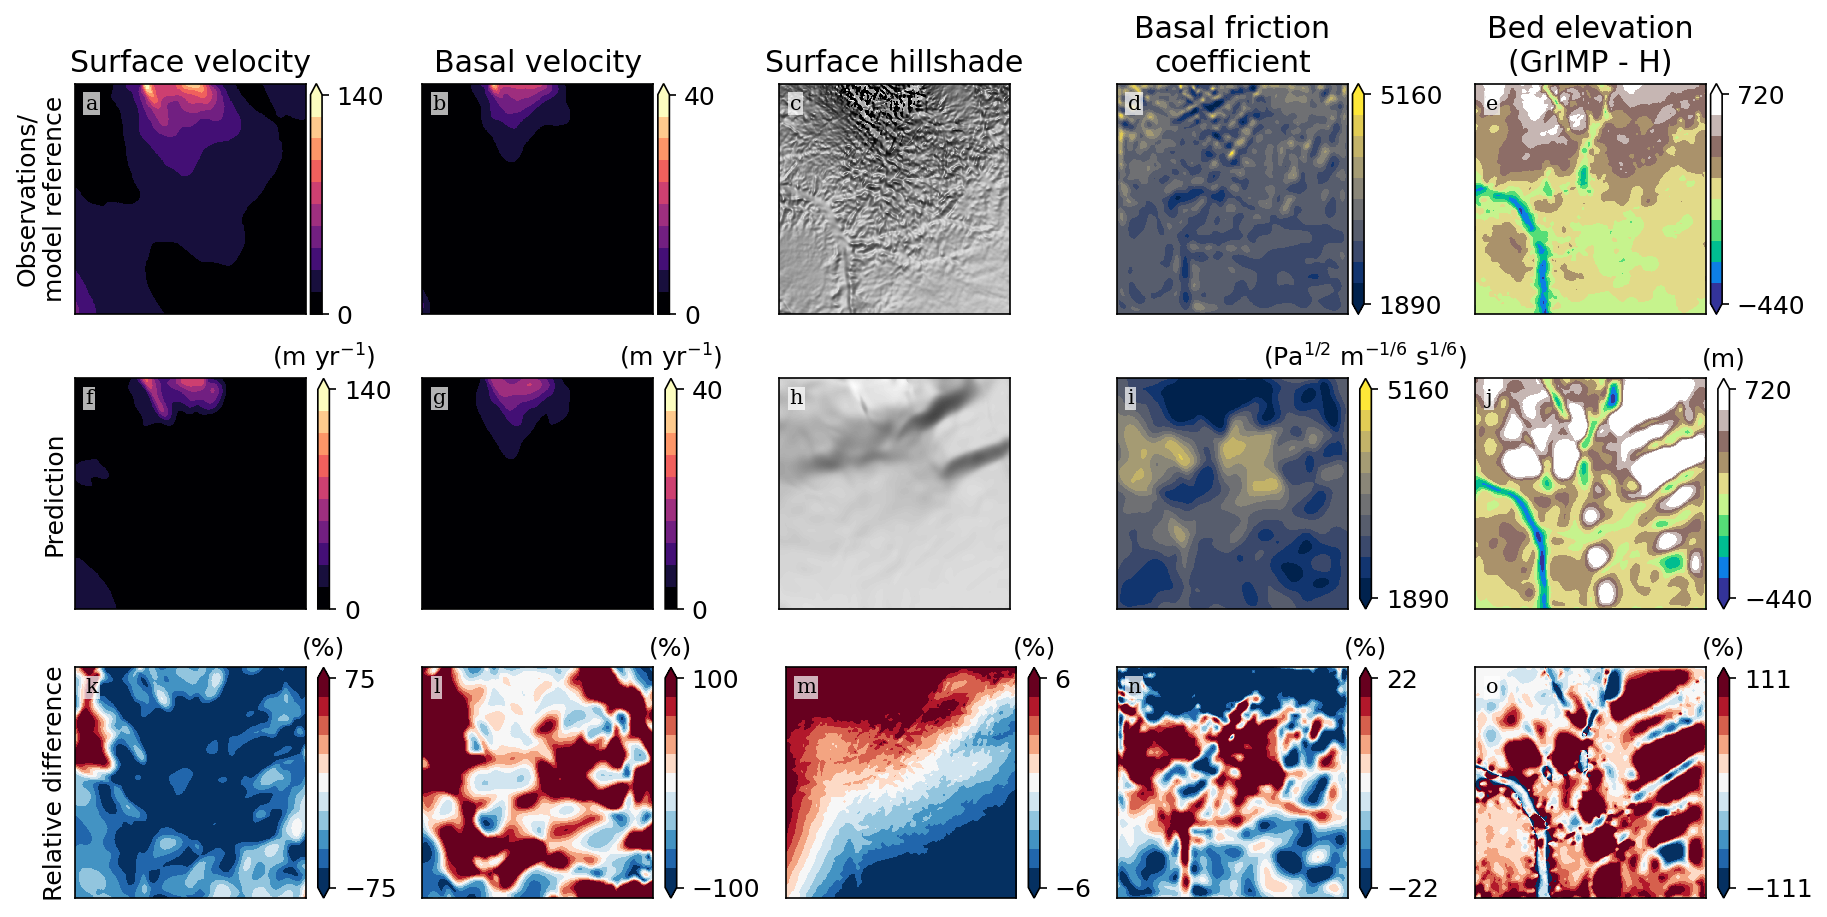

In [9]:
# Get colorbar ranges for plotting data
cranges = {name:[np.round(np.min(ref_data_plot[name]),decimals=-1), np.round(np.max(ref_data_plot[name]),decimals=-1)] for name in ref_names}
# cranges["u_base"] = [-10, 10]
# cranges["v_base"] = [-10, 10]
# cranges["vel_base"] = [0, 10]
cranges["hs"] = [0.0, 1.0]

q75_pd = {name:np.quantile(np.abs(perc_diff[name]),0.75) for name in perc_diff.keys()}
cranges_pd = {name:[np.round(-1*q75_pd[name]), np.round(q75_pd[name])] for name in perc_diff.keys()}
if np.max(cranges_pd["vel_base"]) > 100:
    cranges_pd["vel_base"] = [-100, 100]

clabels = {name:[] for name in ref_names}
# clabels["u"] = "m/yr"
# clabels["v"] = "m/yr"
clabels["vel"] = "(m yr$^\mathrm{-1}$)"
# clabels["u_base"] = "m/yr"
# clabels["v_base"] = "m/yr"
clabels["vel_base"] = "(m yr$^\mathrm{-1}$)"
clabels["hs"] = ""
clabels["C"] = "(Pa$^\mathrm{1/2}$ m$^\mathrm{-1/6}$ s$^\mathrm{1/6}$)"
clabels["bed_elev"] = "(m)"

cmaps = {name:[] for name in ref_names}
# cmaps["u"] = plt.get_cmap("magma", 10)
# cmaps["v"] = plt.get_cmap("magma", 10)
cmaps["vel"] = plt.get_cmap("magma",10)
# cmaps["u_base"] = plt.get_cmap("magma",10)
# cmaps["v_base"] = plt.get_cmap("magma",10)
cmaps["vel_base"] = plt.get_cmap("magma",10)
cmaps["hs"] = plt.get_cmap("gray", 100)
cmaps["C"] = plt.get_cmap("cividis", 10)
cmaps["bed_elev"] = plt.get_cmap("terrain", 10)

cols = len(ref_names)

# Make the plots
import string

titles = {"vel":"Surface velocity", "vel_base":"Basal velocity", "hs":"Surface hillshade", "C":"Basal friction\ncoefficient",
          "bed_elev":"Bed elevation\n(GrIMP - H)"}
extends = {"vel":"max", "vel_base":"max", "hs":"neither","C":"both","bed_elev":"both"}


alphabet = list(string.ascii_lowercase)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12

# for ax, name in zip(axs.ravel(), ref_data.keys()):
fig, axs = plt.subplots(3, cols, figsize=(12,6),dpi=150,layout='constrained')
# fig.subplots_adjust(left=0.1, hspace=0.0, wspace=0.45)
for ax, name in zip(axs[0], ref_data_plot.keys()):
    vr = cranges.setdefault(name, [None, None])
    im = ax.imshow(ref_data_plot[name], interpolation='nearest', cmap=cmaps[name],
                   extent=[X.min(), X.max(), Y.min(), Y.max()],
                   vmin=vr[0], vmax=vr[1],
                   aspect='equal', origin='lower')
    ax.set_title(titles[name])
    ax.tick_params(left = False, right = False , labelleft = False ,
                   labelbottom = False, bottom = False)
    if len(clabels[name]) > 0:
        cbar = plt.colorbar(im, ax=ax, fraction=0.048, location="right", pad=0.02, extend = extends[name], ticks=vr) 
    

for ax, name in zip(axs[1], ref_data_plot.keys()):
    vr = cranges.setdefault(name, [None, None])
    im = ax.imshow(pred_data[name], interpolation='nearest', cmap=cmaps[name],
                   extent=[X.min(), X.max(), Y.min(), Y.max()],
                   vmin=vr[0], vmax=vr[1],
                   origin='lower', aspect='equal')
    # ax.set_title(name+"_pred")
    ax.tick_params(left = False, right = False , labelleft = False , 
                   labelbottom = False, bottom = False)
    if len(clabels[name]) > 0:
        cbar = fig.colorbar(im, ax=ax, fraction=0.048, location="right", extend = extends[name], ticks=vr) 
        cbar.ax.set_title(clabels[name],fontsize='medium')

# fig, axs = plt.subplots(math.floor(n/cols), cols, figsize=(12,9))
for ax, name in zip(axs[2], perc_diff.keys()):
    vr = cranges_pd.setdefault(name, [None, None])
    im = ax.imshow(perc_diff[name], interpolation='nearest', cmap=plt.get_cmap('RdBu_r',11),
                   extent=[X.min(), X.max(), Y.min(), Y.max()],
                   vmin=vr[0], vmax=vr[1],
                   aspect='equal', origin='lower')
    ax.tick_params(left = False, right = False , labelleft = False ,
                   labelbottom = False, bottom = False)
    cbar = fig.colorbar(im, ax=ax, fraction = 0.048, location="right", extend="both",ticks=vr) 
    cbar.ax.set_title("(%)",fontsize='medium') #, y=1.15, rotation=0)

axs[0,0].set_ylabel("Observations/\nmodel reference")
axs[1,0].set_ylabel("Prediction")
axs[2,0].set_ylabel("Relative difference")

for ax, label in zip(axs.ravel(), alphabet):
    ax.annotate(label,
    xy=(0, 1), xycoords='axes fraction',
    xytext=(+0.5, -0.5), textcoords='offset fontsize',
    fontsize='small', verticalalignment='top', fontfamily='serif',
    bbox=dict(facecolor='1.0', edgecolor='none', pad=1.0,alpha=0.7))

# if 'hp' in locals():
#     plt.savefig(hp["save_path"]+"/2Dsolutions")
# else:
#     plt.savefig(experiment.params.param_dict["save_path"]+"/2Dsolutions")

Loading history


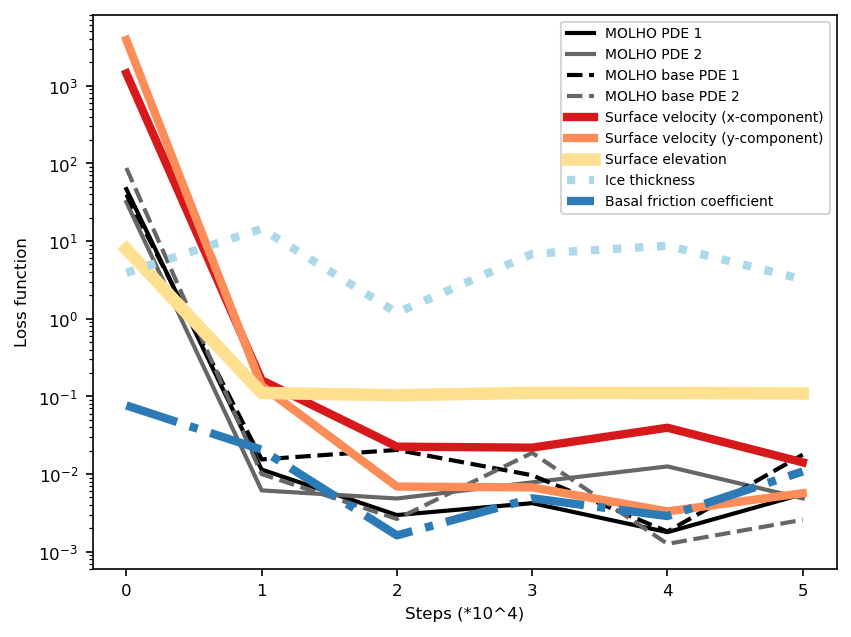

In [5]:
# Plot history on one axis
from pinnicle.utils.history import load_dict_from_json

# Plot Loss History on one axis
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 8

if 'hp' in locals():
    print('Using already loaded history')
    history = experiment.history.history
    # loss_keys = [k for k in experiment.history.history.keys() if k != "steps"]
else:
    print('Loading history')
    history = load_dict_from_json(model_path,"history.json")
    # loss_keys = [k for k in experiment.history.keys() if k != "steps"]



fig = plt.figure(dpi = 150) 
plt.plot(history['fMOLHO 1'], "k-", label="MOLHO PDE 1", linewidth=2)
plt.plot(history['fMOLHO 2'], label="MOLHO PDE 2", linestyle="-", c='0.4', linewidth=2)
plt.plot(history['fMOLHO base 1'], "k--", label="MOLHO base PDE 1", linewidth=2)
plt.plot(history['fMOLHO base 2'], label="MOLHO base PDE 2", linestyle="--",linewidth=2, c='0.4')
plt.plot(history['u'], label='Surface velocity (x-component)', linewidth=4, c='#d7191c')
plt.plot(history['v'], label='Surface velocity (y-component)', linewidth=4, c='#fc8d59')
plt.plot(history['s'], label='Surface elevation', linewidth=6, c='#fee090')
plt.plot(history['H'], label='Ice thickness', linewidth=4, c='#abd9e9', linestyle=":")
plt.plot(history['C'], label='Basal friction coefficient', linewidth=4, linestyle="-.", c='#2c7bb6')

plt.legend(loc=1,fontsize='small')
plt.yscale('log')
plt.xlabel('Steps (*10^4)')
plt.ylabel('Loss function')

if 'hp' in locals():
    plt.savefig(hp["save_path"]+"/History_1ax")
else:
    plt.savefig(experiment.params.param_dict["save_path"]+"/History_1ax")

True
(90000,)


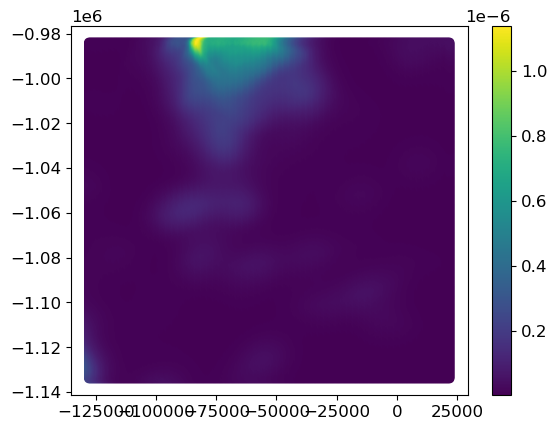

In [20]:
data = mat73.loadmat('Ryder_vel_base_ms.mat')
# Test for zeros
if 0 in data['md_u_base']:
    print('The array contains zeroes')

print(np.all(data['md_v_base']))
print(np.shape(data['y']))
data['vel_base'] = np.sqrt(data['md_v_base']**2 + data['md_u_base']**2)
plt.scatter(data['x'], data['y'], c=data['vel_base'])
plt.colorbar()

Use filtered surface speed with elevation azimuth and calculate along-flow surface slope...
Use filtered surface speed with elevation azimuth and calculate along-flow surface slope...


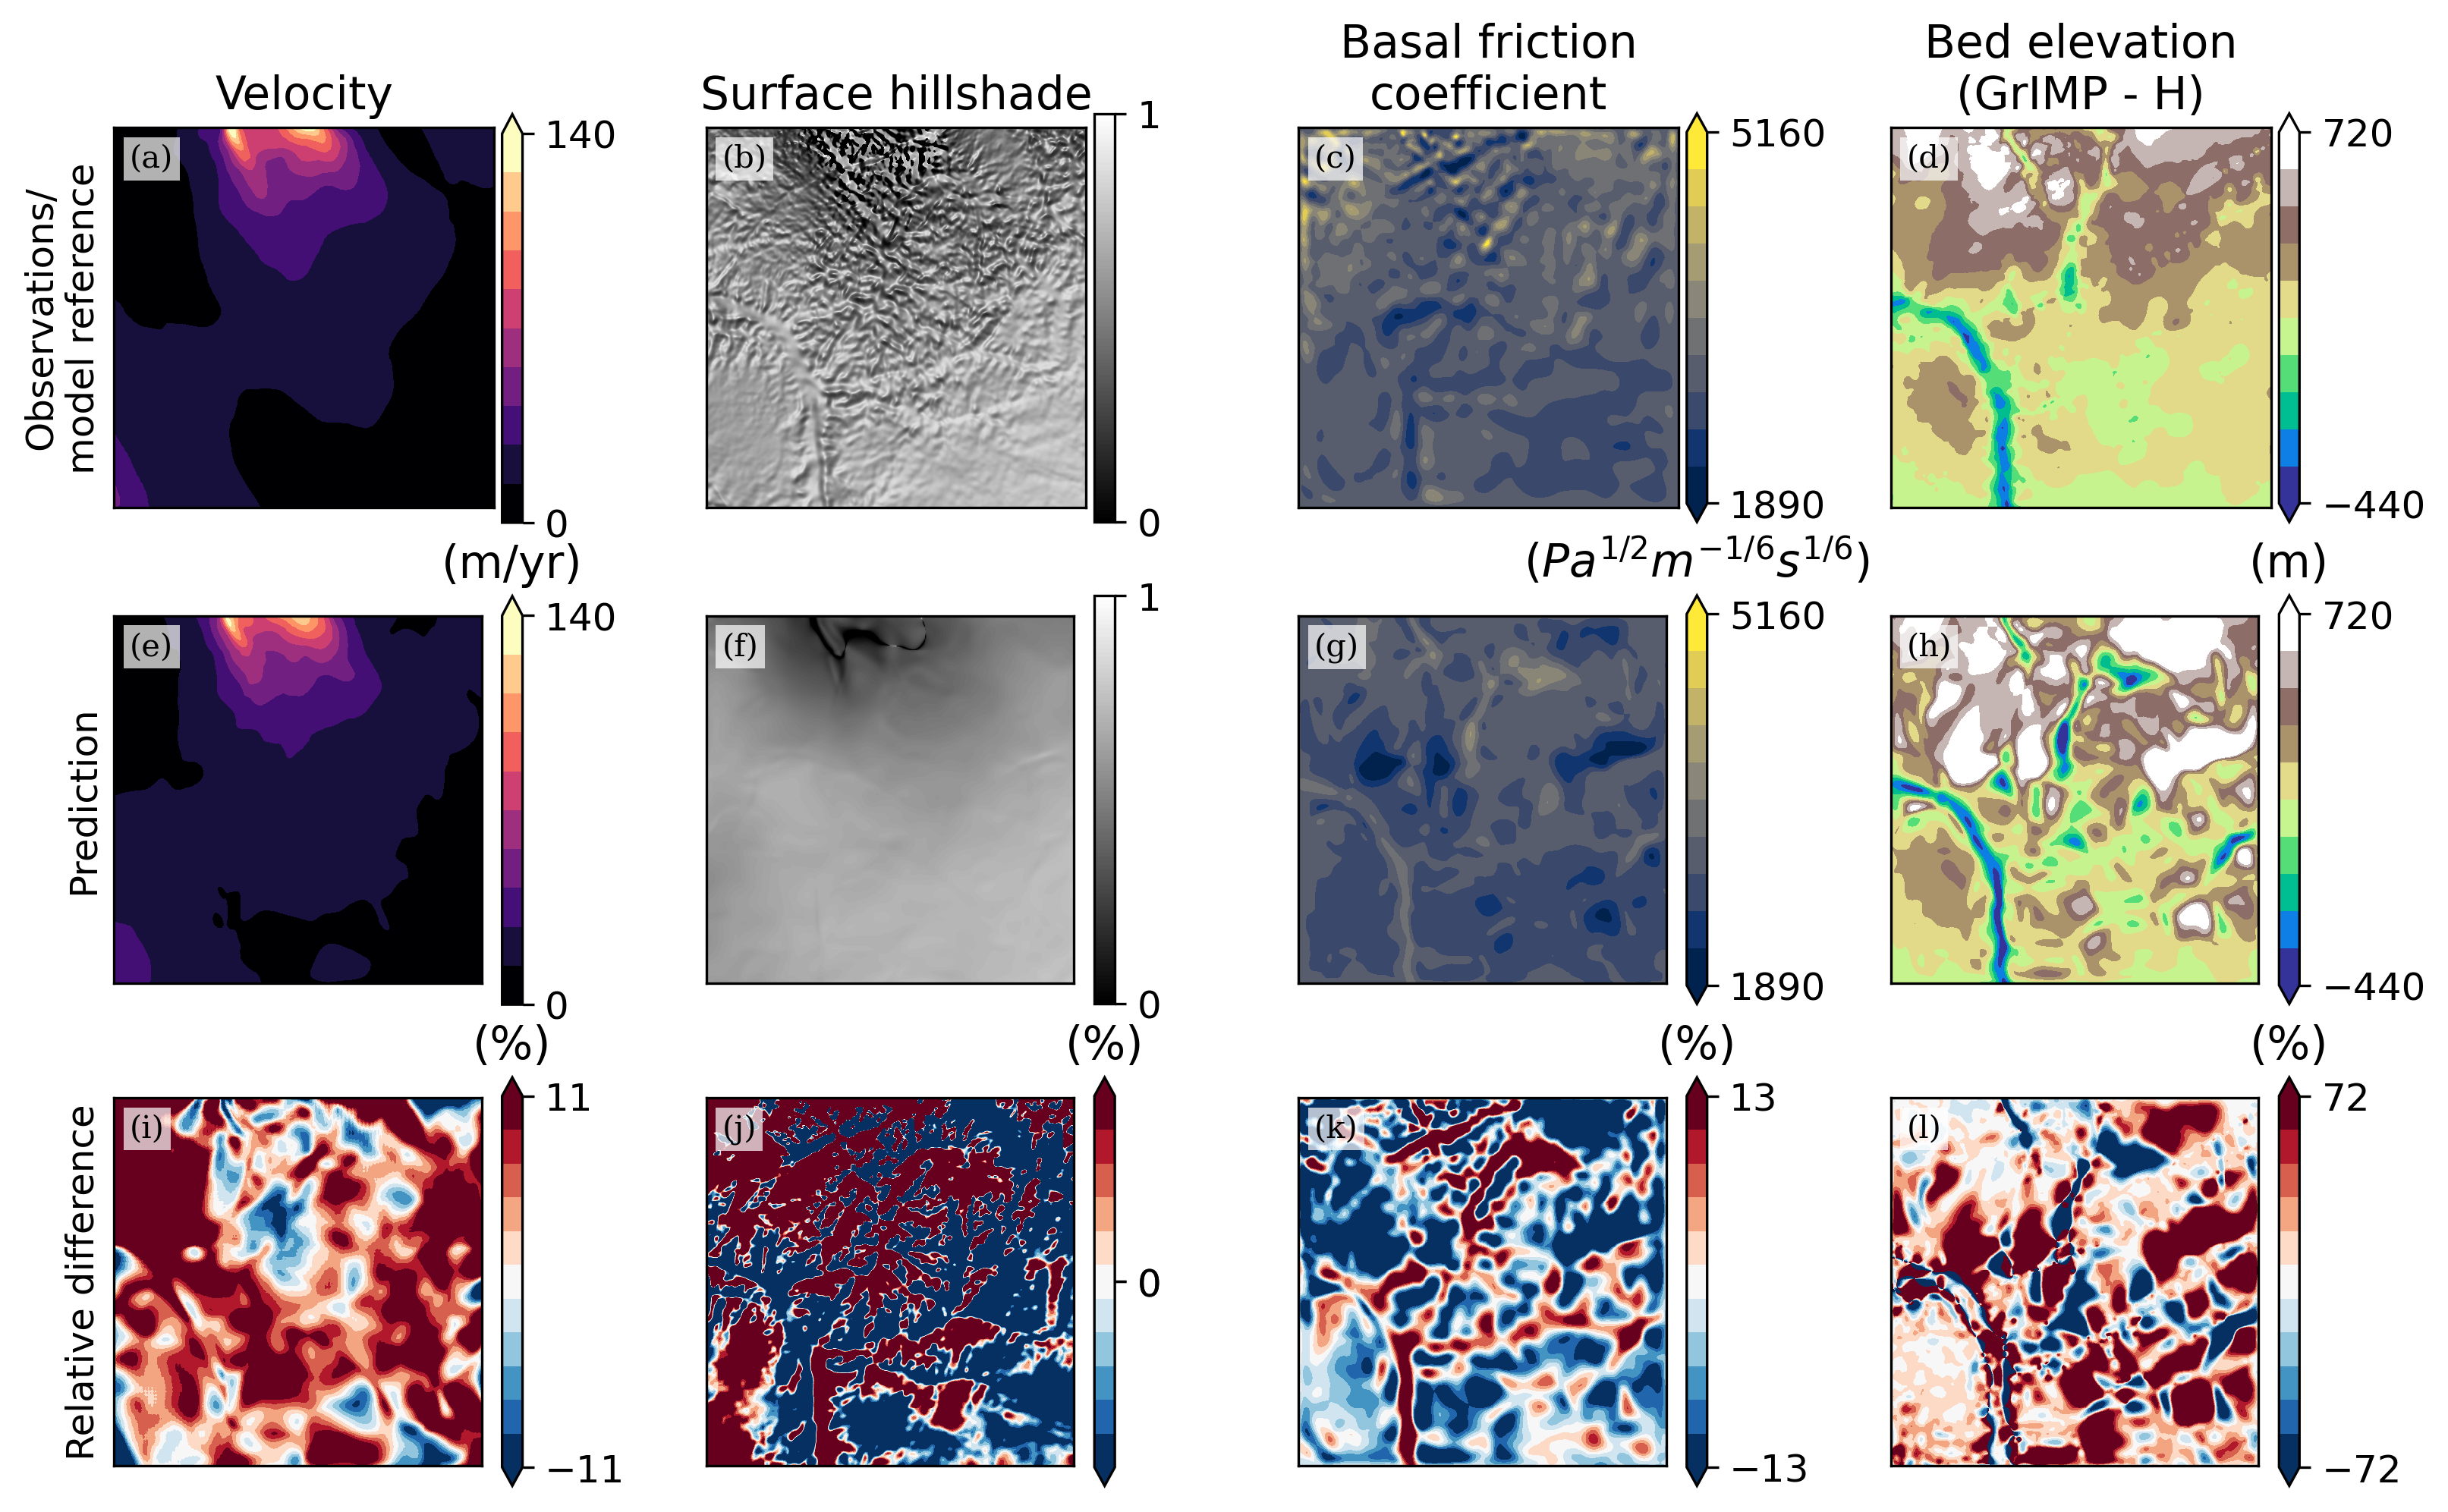

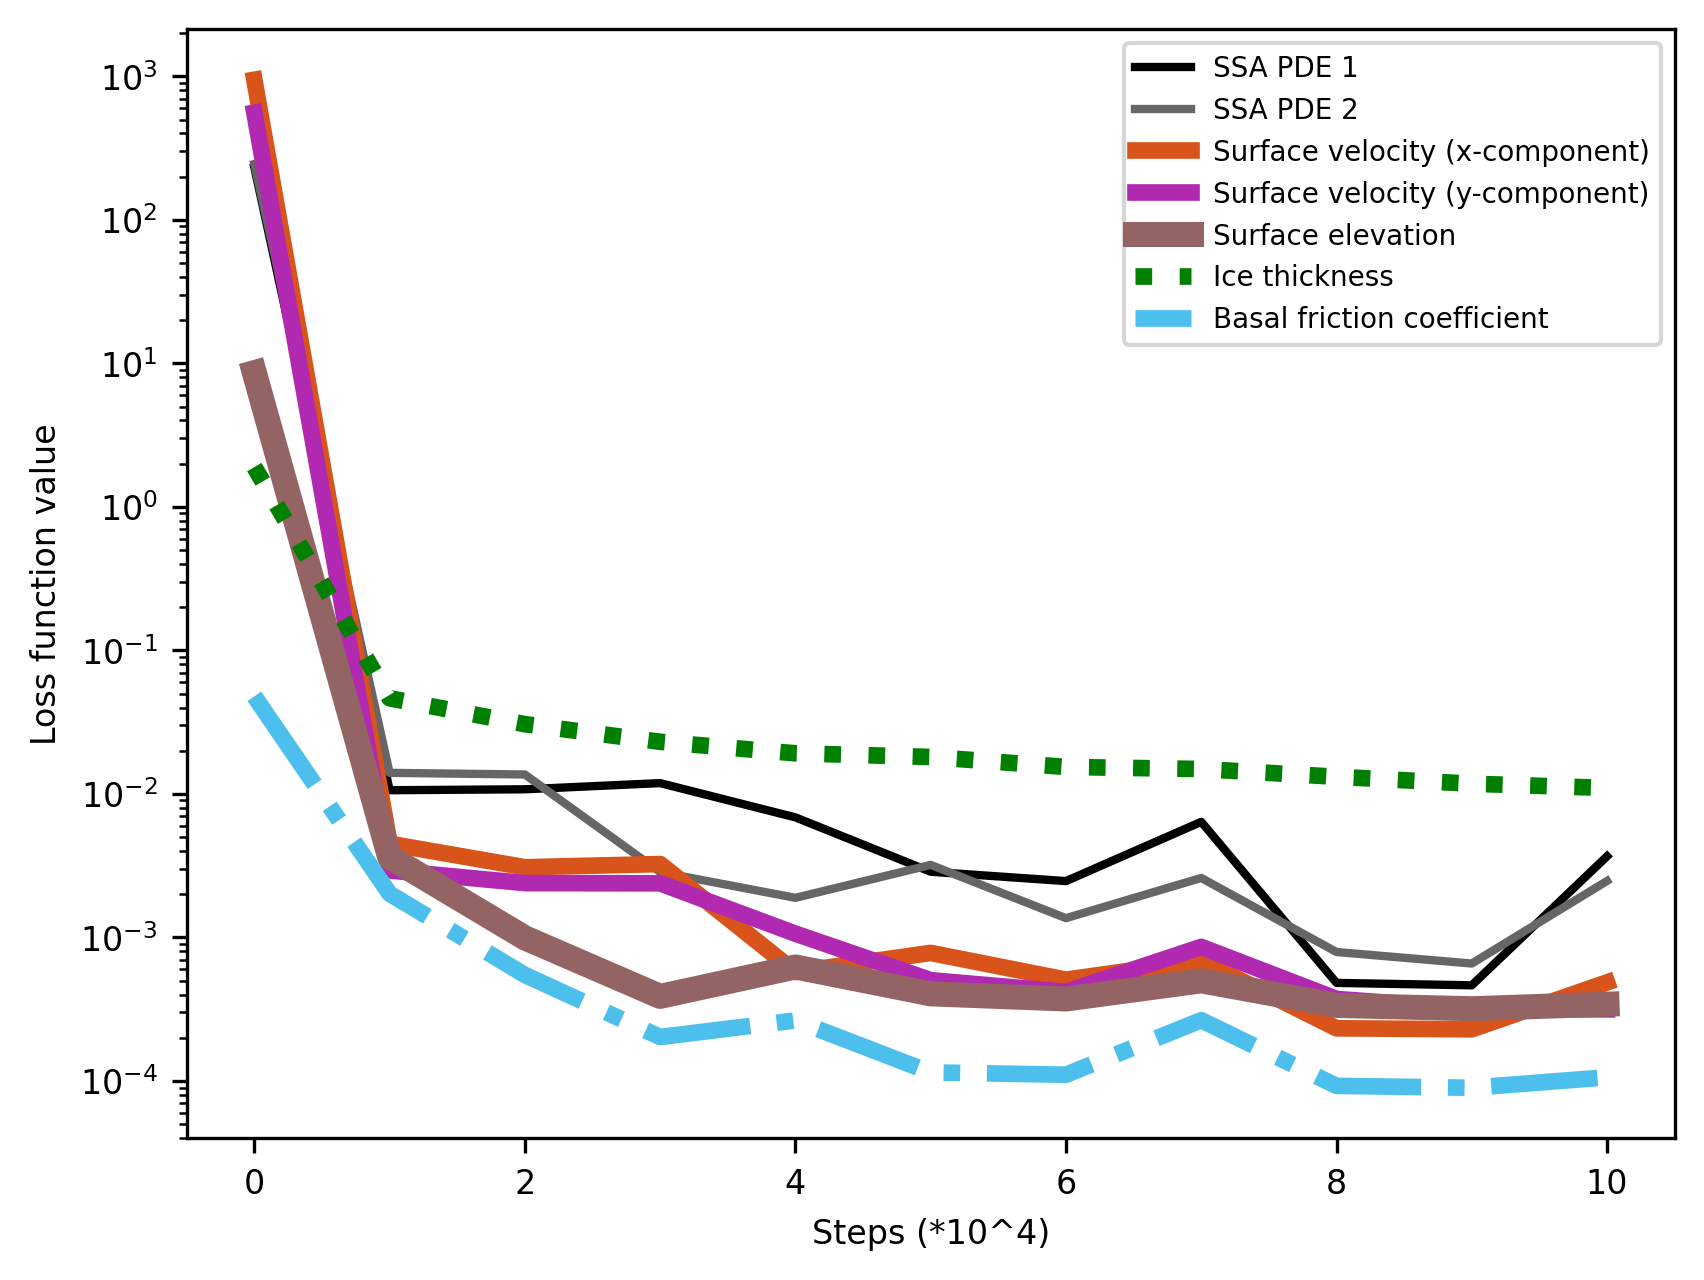

In [9]:
# Prepare plotting data - SSA

grid_size = 501
# generate grid_size x grid_size mesh on the domain
X, Y = np.meshgrid(np.linspace(experiment.params.nn.input_lb[0], experiment.params.nn.input_ub[0], grid_size),
                   np.linspace(experiment.params.nn.input_lb[1], experiment.params.nn.input_ub[1], grid_size))
X_nn = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

X_ref=experiment.model_data.data["ISSM"].X_dict
X_ref = np.hstack((X_ref['x'].flatten()[:,None],X_ref['y'].flatten()[:,None]))

resolution = X[0,1] - X[0,2]
yts = pinn.physics.Constants().yts

# reference data
sol_ref=experiment.model_data.data["ISSM"].data_dict
ref_data = {k:griddata(X_ref, sol_ref[k].flatten(), (X, Y), method='cubic') for k in experiment.params.nn.output_variables if k in sol_ref}

ref_data["u"] = yts*ref_data["u"]
ref_data["v"] = yts*ref_data["v"]
ref_data_plot = {"vel": np.sqrt(np.square(ref_data["u"]) + np.square(ref_data["v"])),
                 "hs":[], "C":ref_data["C"], "bed_elev":ref_data["s"] - ref_data["H"]}

# Get hillshade for reference surface
ref_az = shadecalc_pre(ref_data["s"], ref_data["u"], ref_data["v"], resolution)
#                                         dem         dx           az                 el             zf
ref_data_plot["hs"] = shadecalc_alt(ref_data["s"], resolution, ref_az + (np.pi/2), np.radians(30), 200) # hillshade lit across flow azimuth

ref_names = ref_data_plot.keys()

# predicted solutions
sol_pred = experiment.model.predict(X_nn)
pred_data = {k:np.reshape(sol_pred[:,i:i+1], X.shape) for i,k in enumerate(experiment.params.nn.output_variables)}
data_names = pred_data.keys()

pred_data["u"] = yts*pred_data["u"]
pred_data["v"] = yts*pred_data["v"]
pred_data["vel"] = np.sqrt(np.square(pred_data["u"]) + np.square(pred_data["v"]))
pred_data["bed_elev"] = ref_data["s"] - pred_data["H"]

# Get hillshade for predicted surface
pred_az = shadecalc_pre(pred_data["s"], pred_data["u"], pred_data["v"], resolution)
#                                         dem         dx           az                 el             zf
pred_data["hs"] = shadecalc_alt(pred_data["s"], resolution, pred_az + (np.pi / 2), np.radians(30), 200) # hillshade lit across flow azimuth

# Get percent differences
perc_diff = {}
perc_diff["vel"]= ((pred_data["vel"] - ref_data_plot["vel"])/ref_data_plot["vel"])*100
perc_diff["s"]= ((pred_data["s"] - ref_data["s"])/ref_data["s"])*100
perc_diff["C"]= ((pred_data["C"] - ref_data_plot["C"])/ref_data_plot["C"])*100
perc_diff["bed_elev"]= ((pred_data["bed_elev"] - ref_data_plot["bed_elev"])/ref_data_plot["bed_elev"])*100


# Get colorbar ranges for plotting data
cranges = {name:[np.round(np.min(ref_data_plot[name]),decimals=-1), np.round(np.max(ref_data_plot[name]),decimals=-1)] for name in ref_names}
cranges["hs"] = [0.0, 1.0]

q75_pd = {name:np.quantile(np.abs(perc_diff[name]),0.75) for name in perc_diff.keys()}
cranges_pd = {name:[np.round(-1*q75_pd[name]), np.round(q75_pd[name])] for name in perc_diff.keys()}


clabels = {name:[] for name in ref_names}
clabels["vel"] = "(m/yr)"
clabels["hs"] = ""
clabels["C"] = "($Pa^{1/2} m^{-1/6} s^{1/6}$)"
clabels["bed_elev"] = "(m)"

cmaps = {name:[] for name in ref_names}
cmaps["vel"] = plt.get_cmap("magma",10)
cmaps["hs"] = plt.get_cmap("gray", 100)
cmaps["C"] = plt.get_cmap("cividis", 10)
cmaps["bed_elev"] = plt.get_cmap("terrain", 10)

cols = len(ref_names)

# Make the plots
import string

titles = {"vel":"Velocity", "hs":"Surface hillshade", "C":"Basal friction\ncoefficient",
          "bed_elev":"Bed elevation\n(GrIMP - H)"}
extends = {"vel":"max", "hs":"neither","C":"both","bed_elev":"both"}


alphabet = list(string.ascii_lowercase)
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12

# for ax, name in zip(axs.ravel(), ref_data.keys()):
fig, axs = plt.subplots(3, cols, figsize=(12,8),dpi=300)
fig.subplots_adjust(left=0.1, hspace=0.1, wspace=0.45)
for ax, name in zip(axs[0], ref_data_plot.keys()):
    vr = cranges.setdefault(name, [None, None])
    im = ax.imshow(ref_data_plot[name], interpolation='nearest', cmap=cmaps[name],
                   extent=[X.min(), X.max(), Y.min(), Y.max()],
                   vmin=vr[0], vmax=vr[1],
                   aspect='equal', origin='lower')
    ax.set_title(titles[name])
    ax.tick_params(left = False, right = False , labelleft = False ,
                   labelbottom = False, bottom = False)
    cbar = plt.colorbar(im, ax=ax, fraction=0.05, location="right", pad=0.02, extend = extends[name], ticks=vr) 
    

for ax, name in zip(axs[1], ref_data_plot.keys()):
    vr = cranges.setdefault(name, [None, None])
    im = ax.imshow(pred_data[name], interpolation='nearest', cmap=cmaps[name],
                   extent=[X.min(), X.max(), Y.min(), Y.max()],
                   vmin=vr[0], vmax=vr[1],
                   origin='lower', aspect='equal')
    # ax.set_title(name+"_pred")
    ax.tick_params(left = False, right = False , labelleft = False , 
                   labelbottom = False, bottom = False)
    cbar = fig.colorbar(im, ax=ax, fraction=0.05, location="right", extend = extends[name], ticks=vr) 
    cbar.ax.set_title(clabels[name])

# fig, axs = plt.subplots(math.floor(n/cols), cols, figsize=(12,9))
for ax, name in zip(axs[2], perc_diff.keys()):
    vr = cranges_pd.setdefault(name, [None, None])
    im = ax.imshow(perc_diff[name], interpolation='nearest', cmap=plt.get_cmap('RdBu_r',11),
                   extent=[X.min(), X.max(), Y.min(), Y.max()],
                   vmin=vr[0], vmax=vr[1],
                   aspect='equal', origin='lower')
    ax.tick_params(left = False, right = False , labelleft = False ,
                   labelbottom = False, bottom = False)
    cbar = fig.colorbar(im, ax=ax, fraction = 0.05, location="right", extend="both",ticks=vr) 
    cbar.ax.set_title("(%)") #, y=1.15, rotation=0)

axs[0,0].set_ylabel("Observations/\nmodel reference")
axs[1,0].set_ylabel("Prediction")
axs[2,0].set_ylabel("Relative difference")

for ax, label in zip(axs.ravel(), alphabet):
    ax.annotate("("+label+")",
    xy=(0, 1), xycoords='axes fraction',
    xytext=(+0.5, -0.5), textcoords='offset fontsize',
    fontsize='small', verticalalignment='top', fontfamily='serif',
    bbox=dict(facecolor='1.0', edgecolor='none', pad=2.0,alpha=0.7))

# plt.savefig(hp["save_path"]+"/2Dsolutions")

plt.savefig(experiment.params.param_dict["save_path"]+"/2Dsolutions")

# Plot history on one axis
from pinnicle.utils.history import load_dict_from_json
experiment.history = load_dict_from_json(model_path,"history.json")

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 8

loss_keys = [k for k in experiment.history.keys() if k != "steps"]

fig = plt.figure(dpi = 300) 
plt.plot(experiment.history['fSSA_VB1'], "k-", label="SSA PDE 1", linewidth=2)
plt.plot(experiment.history['fSSA_VB2'], label="SSA PDE 2", linestyle="-", c='0.4', linewidth=2)
plt.plot(experiment.history['u'], label='Surface velocity (x-component)', linewidth=4, c=[0.85,0.33,0.10])
plt.plot(experiment.history['v'], label='Surface velocity (y-component)', linewidth=4, c=[0.69,0.16,0.69])
plt.plot(experiment.history['s'], label='Surface elevation', linewidth=6, c=[0.58,0.39,0.39])
plt.plot(experiment.history['H'], label='Ice thickness', linewidth=4, c='g', linestyle=":")
plt.plot(experiment.history['C'], label='Basal friction coefficient', linewidth=4, linestyle="-.", c=[0.30,0.75,0.93])

plt.legend(loc=1,fontsize='small')
plt.yscale('log')
plt.xlabel('Steps (*10^4)')
plt.ylabel('Loss function value')

plt.savefig(experiment.params.param_dict["save_path"]+"/History_1ax")

**Below this is old and unpolished code for playing around**

In [4]:
# How to print different sections of model
# print(experiment.params.training)

# print(experiment.params.nn.output_lb)
# print(experiment.model.predict)

import deepxde.backend as bkd

resolution = 200
    # generate 200x200 mesh on the domain
X, Y = np.meshgrid(np.linspace(experiment.params.nn.input_lb[0], experiment.params.nn.input_ub[0], resolution),
                   np.linspace(experiment.params.nn.input_lb[1], experiment.params.nn.input_ub[1], resolution))
X_nn = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))
grid_size = 2.0*(((experiment.params.nn.input_ub[0] - experiment.params.nn.input_lb[0])/resolution)**2+
                 ((experiment.params.nn.input_ub[1] - experiment.params.nn.input_lb[1])/resolution)**2)**0.5
if bkd.backend_name == "pytorch":
    grid_size = bkd.to_numpy(grid_size)

# predicted solutions
sol_pred = experiment.model.predict(X_nn)
plot_data = {k+"_pred":np.reshape(sol_pred[:,i:i+1], X.shape) for i,k in enumerate(experiment.params.nn.output_variables)}


[-3.1709792e-04 -3.1709792e-04 -1.0000000e+03  1.0000000e+01
  1.0000000e-02]
<bound method Model.predict of <deepxde.model.Model object at 0x1504e5075630>>


In [66]:
# print(len(experiment.model_data.X['C']))
# print(len(experiment.model_data.X['H']))
# print(experiment.model_data.sol)
# print(experiment.params.param_dict['B'])
print(vars(experiment.params.physics))

{'param_dict': {'data': {'ISSM': {'data_path': './Models/Ryder_test_I05-Dec-2024_2.mat', 'data_size': {'u': 5000, 'v': 5000, 's': 5000, 'H': None, 'C': 5000, 'vel': 5000}}, 'ft': {'data_path': './Ryder_xyz.mat', 'data_size': {'H': 8000}, 'name_map': {'H': 'thickness'}, 'X_map': {'x': 'x', 'y': 'y'}, 'source': 'mat'}}, 'epochs': 100000, 'learning_rate': 0.0005, 'loss_function': 'MSE', 'save_path': './PINNs/Ryder_test_I05-Dec-2024_2_P16-Dec-24_2', 'is_save': True, 'is_plot': True, 'activation': 'tanh', 'initializer': 'Glorot uniform', 'num_neurons': 20, 'num_layers': 6, 'input': ['y', 'x'], 'shapefile': './Ryder_32_09.exp', 'num_collocation_points': 10000, 'equations': {'SSA': {'scalar_variables': {'B': 200000000.0, 'n': 4}, 'data_weights': [99451929600.0, 99451929600.0, 5e-06, 1e-06, 1e-08]}}, 'fft': True, 'sigma': 5, 'num_fourier_feature': 30, 'B': [[6.605542387359734, 1.1229533305596202, 7.43116665398821, -3.535552712628588, 1.424607792835342, -0.7693938490405215, 2.957133272478977, -